# Cars problem (`2021-10-31`)

The problem is described in this Math.SE question: https://math.stackexchange.com/questions/3033154/expected-number-of-coin-flips-until-all-cars-move-to-end-of-array.

As `zoidberg` mentions in the comments, it can be modelled as a TASEP in a finite interval. To be more precise, it can be seen as a version of TASEP in a finite interval, with discrete time and parallel update.

## Simulations

We start by simulating an instance of the problem:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
plt.rcParams['figure.figsize'] = (15, 7)

There are two basic encodings: we can model the configuration as a boolean array or as an array of integer positions. In this case we will use the array of positions encoding, using $n$ for the number of cars and $m$ for the number of spaces in front of them (both values are equal in the problem as specified). 

In [3]:
def simulation_full(n, m, max_steps):
    # we represent each simulation by the car positions C_i, adding a sentinel element at the end
    cars = np.arange(n + 1)
    cars[-1] += m
    history = [np.copy(cars)]
    for i in range(max_steps):
        coin_flips = np.random.choice([0, 1], size=n)
        steps_mask = (cars[:-1] + 1 < cars[1:]).astype('int')
        steps = coin_flips & steps_mask
        cars[:-1] += steps
        history.append(np.copy(cars))
        if history[-1][0] == m:
            break
    return np.array(history)

In [4]:
%%time
N = 500
np.random.seed(1337)
history = simulation_full(N, N, 10**6)
assert history[-1, 0] == N

CPU times: user 71 ms, sys: 10.6 ms, total: 81.6 ms
Wall time: 51 ms


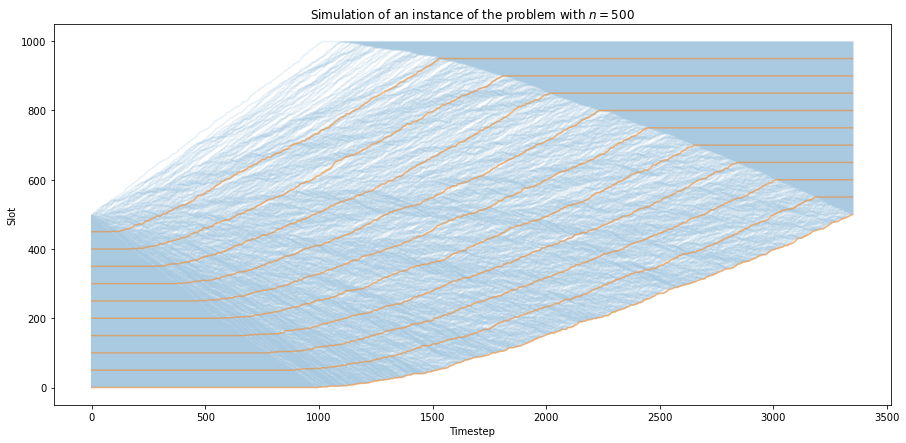

In [5]:
plt.clf()
plt.plot(history[:, :-1], color='C0', alpha=0.1)
plt.plot(history[:, :-1:50], color='C1', alpha=0.5)
plt.title('Simulation of an instance of the problem with $n = %d$' % N)
plt.xlabel('Timestep')
plt.ylabel('Slot')
plt.show()

We use orange to mark the trajectories of the cars with indices that are multiple of 50. Note the arrival of $C_0$ will be the desired number of timesteps.

To get an idea of how the expected number of timesteps varies with $n$, we can do a number of simulations:

In [6]:
def simulation(n, num_samples, max_steps):
    # we represent each simulation by the car positions C_i, adding a sentinel element at the end
    cars = np.tile(np.arange(n + 1), (num_samples, 1))
    cars[:, -1] += n
    results = []
    for i in range(max_steps):
        coin_flips = np.random.choice([0, 1], size=(num_samples, n))
        steps_mask = (cars[:, :-1] + 1 < cars[:, 1:]).astype('int')
        steps = coin_flips & steps_mask
        cars[:, :-1] += steps
        results.append(((cars[:, 0] == n).sum(), (cars[:, -2] == 2 * n - 1).sum()))
        if results[-1] == (num_samples, num_samples):
            break
    return np.array(results)

def estimate_mean_timesteps(max_n, num_samples):
    mean_timesteps = []
    for n in range(1, max_n + 1):
        results = simulation(n, num_samples, n * 20)[:, 0]
        assert results[-1] == num_samples
        arrivals = np.diff(results)
        mean_timesteps.append(np.sum(arrivals * np.arange(1, len(arrivals) + 1)) / np.sum(arrivals))
    return mean_timesteps

In [7]:
%%time
np.random.seed(1337)
mean_timesteps = estimate_mean_timesteps(500, 100)

CPU times: user 2min 57s, sys: 1.35 s, total: 2min 58s
Wall time: 2min 59s


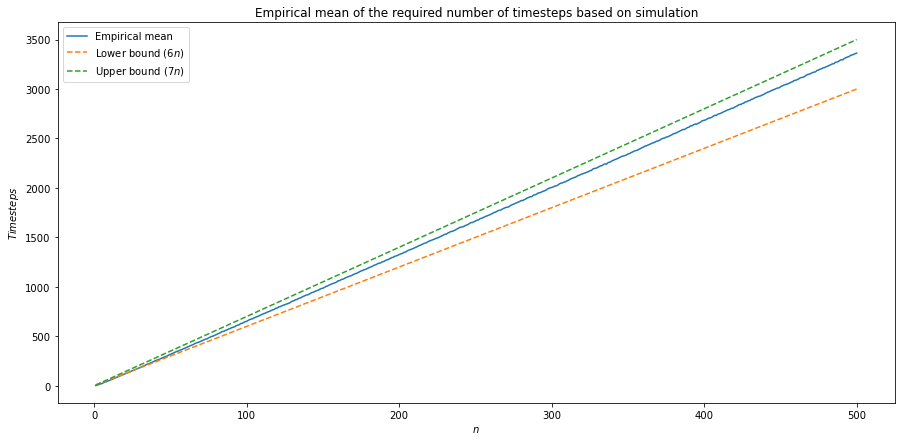

In [8]:
n = np.arange(1, 500 + 1)
plt.clf()
plt.plot(n, mean_timesteps, color='C0', label='Empirical mean')
plt.plot(n, 6 * n, color='C1', linestyle='--', label='Lower bound ($6n$)')
plt.plot(n, 7 * n, color='C2', linestyle='--', label='Upper bound ($7n$)')
plt.title('Empirical mean of the required number of timesteps based on simulation')
plt.xlabel('$n$')
plt.ylabel(r'$Timesteps$')
plt.legend()
plt.show()

We see the expected values seem to be linear in $n$, with a constant between 6 and 7.

## Theoretical analysis

### Adapting existing results for unrestricted TASEP

We will follow the analysis of [Random Domino Tilings and the Arctic Circle Theorem](https://arxiv.org/abs/math/9801068). It applies to a TASEP over all the integers, giving the following result as _Theorem 2_:

  > Fix $\alpha \le \beta$. If one runs the exclusion process starting from the state $x^*$, then the number of particles in the interval $[\alpha n, \beta n]$ at time $n$, normalized by dividing by $n$, converges in probability to $h(\alpha) − h(\beta)$, where
  >
  > $\displaystyle h(u) = \begin{cases}-u & \textrm{for }u < -\frac{1}{2},\\\frac{1 - u}{2} - \frac{1}{2}\sqrt{\frac{1}{2} - u^2} & \textrm{for }-\frac{1}{2}\le u \le \frac{1}{2},\\0 & \textrm{for }u > \frac{1}{2}.\end{cases}$
  
($x^*$ is the state where all the slots with non-positive indices are occupied and those are the only ones occupied.)

Due to the dynamics of TASEP, we know that:

  * A particle doesn't affect the particles in front of it (so the car $C_i$ will not be affected by the cars $C_j$ if $j < i$).
  * The final stop of the particles in front won't affect the time required for a particle to get to its final position (so, if we compute the time required for the car $C_i$ to get to the slot $n + i$, the fact that $C_{i+1}$ stopped at $n + (i + 1)$ won't impact that value).
  
We are interested in the expected position of $C_1$ as a function of time $t$ and we will ignore the final stop for now (so we can use the unrestricted TASEP results). That will be given by $\alpha t$, where $\alpha$ is chosen so that

$\displaystyle h(\alpha) - h(+\infty) = \frac{n}{t}$

$\displaystyle h(\alpha) = \frac{n}{t}$.

We can see that $h(u)$ is monotonically decreasing and that $h\left(-\frac{1}{2}\right) = \frac{1}{2}$, so we will have $\alpha = -\frac{n}{t}$ for $t < 2n$ ($C_1$ takes approximately $2n$ timesteps to move, as that is the time required for the first "hole" to arrive). When $t \ge 2n$,

$\displaystyle \frac{1 - \alpha}{2} - \frac{1}{2}\sqrt{\frac{1}{2} - \alpha^2} = \frac{n}{t}$

$\displaystyle \alpha = \frac{1}{2}\left(-\frac{2}{t}\sqrt{n t - n^2} - \frac{2 n}{t} + 1\right)$

Putting it all together:

$\displaystyle C_1(t) = \begin{cases}-n & \textrm{for }t < 2n,\\-\sqrt{n t - n^2} - n + \frac{t}{2} & \textrm{for }t \ge 2n\end{cases}$.

Checking continuity:

$\displaystyle -\sqrt{n (2n) - n^2} - n + \frac{2n}{2} = -\sqrt{2n^2 - n^2} - n + n = -\sqrt{n^2} = -n$

### Checking consistency with simulation

We will have arrived when we have $C_1(t) = 0$. That will clearly not be the case with $t < 2n$, so substituting in the other expression,

$\displaystyle -\sqrt{n t - n^2} - n + \frac{t}{2} = 0$

$\displaystyle t = 2 \left(2 + \sqrt{2}\right) n \approx 6.8284 n$

Checking in the previous plot:

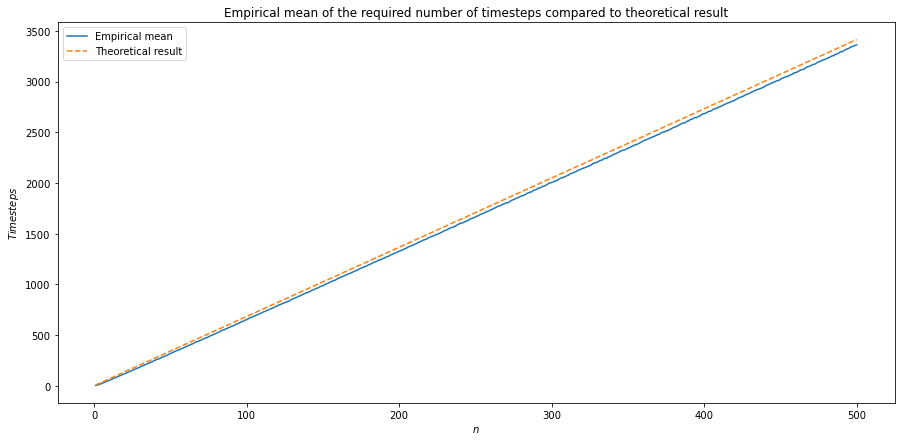

In [9]:
n = np.arange(1, 500 + 1)
plt.clf()
plt.plot(n, mean_timesteps, color='C0', label='Empirical mean')
plt.plot(n, 2 * (2 + np.sqrt(2)) * n, color='C1', linestyle='--', label='Theoretical result')
plt.title('Empirical mean of the required number of timesteps compared to theoretical result')
plt.xlabel('$n$')
plt.ylabel(r'$Timesteps$')
plt.legend()
plt.show()

It seems to match quite well.

### Checking detailed trajectory consistence

To get an extra confirmation of the results, we can compare the observed trajectory with their expected values. To do that we will need to know when they are predicted to reach the desired position.

$\displaystyle C_i(t_i) = i$

$\displaystyle -\sqrt{(n - i) t_i - (n - i)^2} - (n - i) + \frac{t_i}{2} = i$

$\displaystyle t_i = 2 \left(-i + 2 n + \sqrt{2} \sqrt{-i n + n^2}\right)$

In [10]:
def trajectory(t, i, n):
    with np.errstate(invalid='ignore'):
        C_i = -np.sqrt((n - i) * t - (n - i)**2) - (n - i) + t / 2.0
    C_i[t < 2 * (n - i)] = -n + i
    C_i[t > 2 * (-i + 2 * n + np.sqrt(2) * np.sqrt(-i * n + n**2))] = i
    return C_i

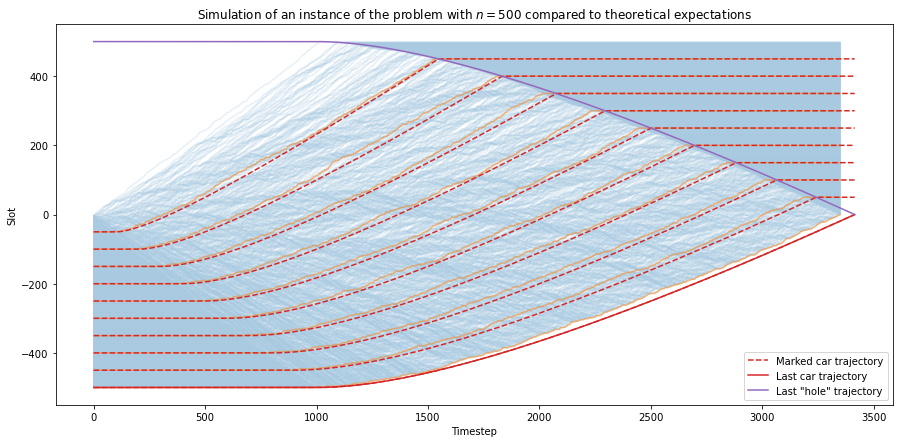

In [11]:
max_t = 2 * (2 + np.sqrt(2)) * N
t = np.linspace(0, max_t, 200)
plt.clf()
plt.plot(history[:, :-1] - N, color='C0', alpha=0.1)
plt.plot(history[:, :-1:50] - N, color='C1', alpha=0.5)
for i in range(0, N, 50):
    plt.plot(t, trajectory(t, i, N), color='C3', linestyle='--', label='Marked car trajectory' if i == 0 else '_')
plt.plot(t, trajectory(t, 0, N), color='C3', label='Last car trajectory')
plt.plot(t, -trajectory(t, 0, N), color='C4', label='Last "hole" trajectory')
plt.title('Simulation of an instance of the problem with $n = %d$ compared to theoretical expectations' % N)
plt.xlabel('Timestep')
plt.ylabel('Slot')
plt.legend()
plt.show()